In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install keras_cv_attention_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.9/786.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.7 MB/s eta 0:00:00


# Copy data

In [7]:
!cp -r "/content/drive/MyDrive/EPL_445_Image_Processing/Project/dataset_1.zip" "/content/"
!unzip "dataset_1.zip"

Archive:  dataset_1.zip
   creating: dataset_1/
  inflating: dataset_1/.DS_Store     
  inflating: __MACOSX/dataset_1/._.DS_Store  
   creating: dataset_1/train/
   creating: dataset_1/val/
  inflating: dataset_1/train/.DS_Store  
  inflating: __MACOSX/dataset_1/train/._.DS_Store  
   creating: dataset_1/train/no_pain/
   creating: dataset_1/train/pain/
  inflating: dataset_1/val/.DS_Store  
  inflating: __MACOSX/dataset_1/val/._.DS_Store  
   creating: dataset_1/val/no_pain/
   creating: dataset_1/val/pain/
  inflating: dataset_1/train/no_pain/101209_w_61-BL1-096_61_0.png  
  inflating: __MACOSX/dataset_1/train/no_pain/._101209_w_61-BL1-096_61_0.png  
  inflating: dataset_1/train/no_pain/082714_m_22-BL1-082_1_0.png  
  inflating: __MACOSX/dataset_1/train/no_pain/._082714_m_22-BL1-082_1_0.png  
  inflating: dataset_1/train/no_pain/082714_m_22-BL1-098_57_0.png  
  inflating: __MACOSX/dataset_1/train/no_pain/._082714_m_22-BL1-098_57_0.png  
  inflating: dataset_1/train/no_pain/112310_m_2

# Handle dataset

In [8]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_cv_attention_models import vit
from tensorflow.keras import layers, Model
import os


# Define constants
data_dir = 'dataset_1' # The dataset. This dataset should have 2 folders named train and val. Each folder must have two subfolders with names "pain" and "no_pain"
img_size = (256, 256)  # Adjust the target_size based on your image dimensions
batch_size = 32

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    shear_range=0.2,      # Shear transformations
    # zoom_range=0.2,       # Zoom transformations
    horizontal_flip=True  # Horizontal flips
)

# Create ImageDataGenerator for validation/test set
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from the training directory
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Flow images from the validation directory
val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # No need to shuffle the validation set
)

Found 1627 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


# Choose and configure model

In [9]:
from keras_cv_attention_models import fastvit
from keras_cv_attention_models import vit

# Load ViT model with adjusted input shape
model = fastvit.FastViT(input_shape=(256, 256, 3), pretrained=False)

# Modify the last layer for binary classification
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
new_output = layers.Dense(2, activation='sigmoid')(model.output)
new_model = Model(inputs=model.inputs, outputs=new_output)

# Train model

In [10]:
# Compile the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = new_model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
51/51 [==============================] - 119s 1s/step - loss: 0.4892 - accuracy: 0.7695 - val_loss: 0.7120 - val_accuracy: 0.5058
Epoch 2/10
51/51 [==============================] - 34s 671ms/step - loss: 0.3331 - accuracy: 0.8549 - val_loss: 4.7518 - val_accuracy: 0.5473
Epoch 3/10
51/51 [==============================] - 34s 664ms/step - loss: 0.2656 - accuracy: 0.8894 - val_loss: 1.4879 - val_accuracy: 0.6374
Epoch 4/10
51/51 [==============================] - 36s 689ms/step - loss: 0.2100 - accuracy: 0.9140 - val_loss: 0.5969 - val_accuracy: 0.6928
Epoch 5/10
51/51 [==============================] - 34s 672ms/step - loss: 0.1659 - accuracy: 0.9281 - val_loss: 0.7304 - val_accuracy: 0.6952
Epoch 6/10
51/51 [==============================] - 35s 677ms/step - loss: 0.1566 - accuracy: 0.9275 - val_loss: 1.1413 - val_accuracy: 0.6443
Epoch 7/10
51/51 [==============================] - 36s 709ms/step - loss: 0.1112 - accuracy: 0.9588 - val_loss: 3.4499 - val_accuracy: 0.5774
E

# Plots

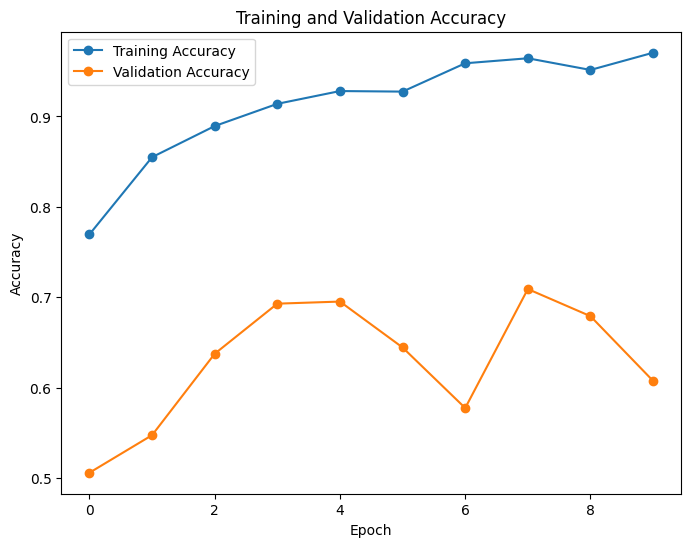

14/14 [==============================] - 3s 125ms/step


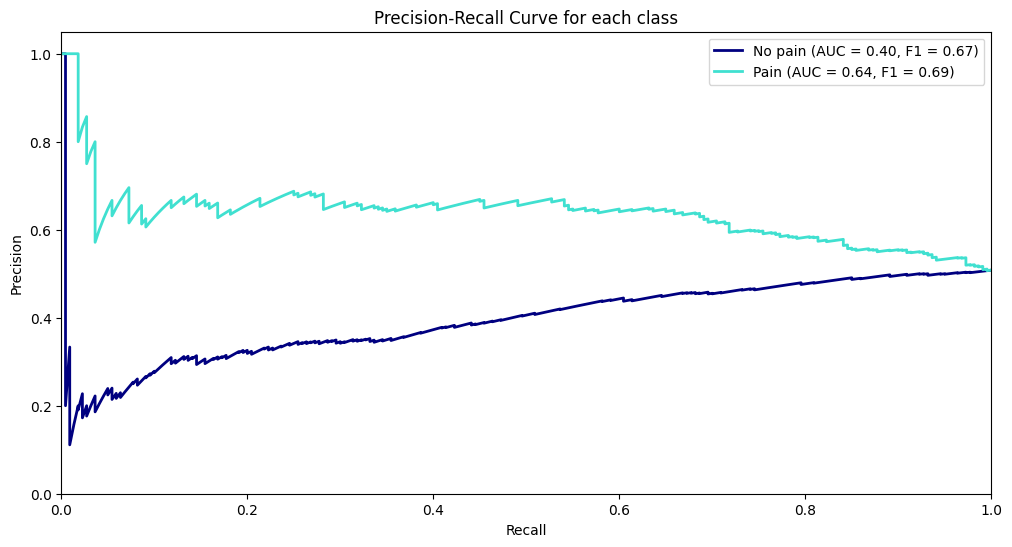

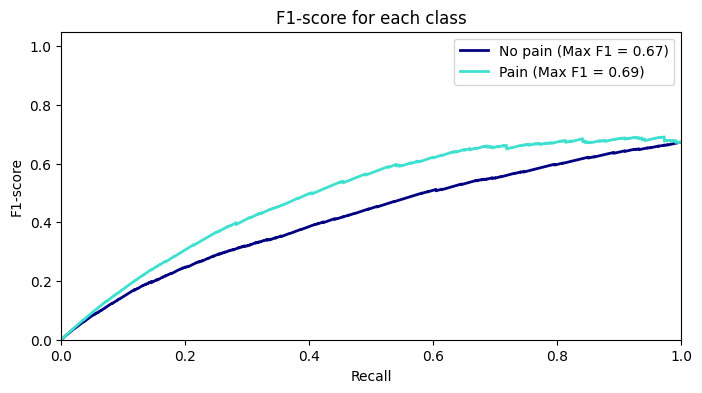

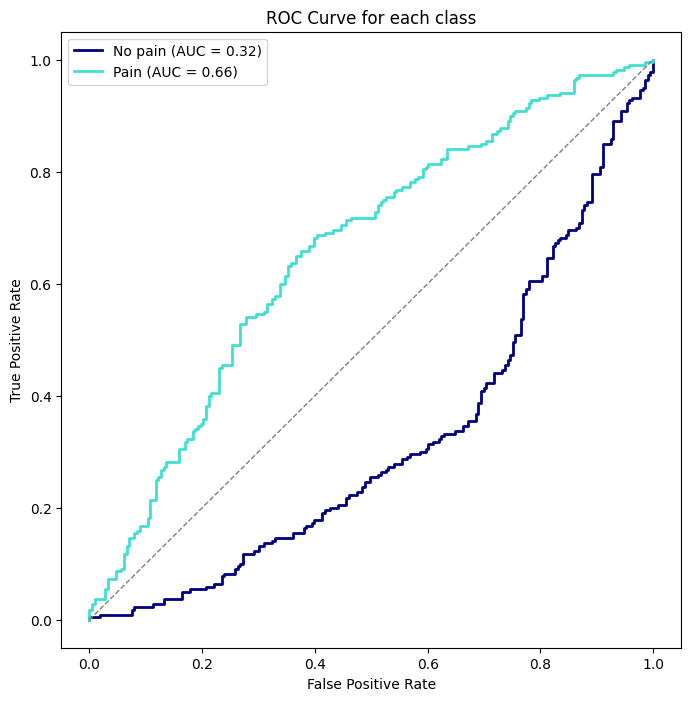

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, f1_score, roc_curve
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

classes = ['No pain', 'Pain']

# Calculate precision, recall, and F1-score on the test set
y_true = val_generator.classes
y_scores = new_model.predict(val_generator)

# Initialize variables for plotting
precision = dict()
recall = dict()
f1 = dict()
area_under_curve = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute precision-recall pairs for each class
for i in range(2):  # Assuming two classes
    precision[i], recall[i], _ = precision_recall_curve(y_true, y_scores[:, i])
    f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    area_under_curve[i] = auc(recall[i], precision[i])

    # Compute ROC curve and ROC area
    fpr[i], tpr[i], _ = roc_curve(y_true, y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true, y_scores[:, i])

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 6))
colors = cycle(['navy', 'turquoise'])
for i, color in zip(range(2), colors):  # Assuming two classes
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f}, F1 = {2:0.2f})'
             ''.format(classes[i], area_under_curve[i], max(f1[i])))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

# Plot F1-score for each class
plt.figure(figsize=(8, 4))
for i, color in zip(range(2), colors):  # Assuming two classes
    plt.plot(recall[i], f1[i], color=color, lw=2,
             label='{0} (Max F1 = {1:0.2f})'
             ''.format(classes[i], max(f1[i])))

plt.xlabel('Recall')
plt.ylabel('F1-score')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('F1-score for each class')
plt.legend(loc="best")
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i, color in zip(range(2), colors):  # Assuming two classes
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="best")
plt.show()